In [ ]:
! pip install pytorch_lightning
! pip install neptune-client

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/mint-condition/imgs.zip /content
!cp /content/drive/MyDrive/mint-condition/card_labels_for_pandas.csv /content
!cp /content/drive/MyDrive/mint-condition/partitioned/partition.p /content
!unzip /content/imgs.zip -d /content/

串流輸出內容已截斷至最後 5000 行。
  inflating: /content/imgs/grade_7_page_22_id_74.jpg  
  inflating: /content/imgs/grade_8_page_49_id_75.jpg  
  inflating: /content/imgs/grade_1_page_21_id_12.jpg  
  inflating: /content/imgs/grade_3_page_11_id_79.jpg  
  inflating: /content/imgs/grade_2_page_97_id_25.jpg  
  inflating: /content/imgs/grade_10_page_69_id_37.jpg  
  inflating: /content/imgs/grade_4_page_59_id_51.jpg  
  inflating: /content/imgs/grade_8_page_20_id_40.jpg  
  inflating: /content/imgs/grade_3_page_20_id_77.jpg  
  inflating: /content/imgs/grade_4_page_80_id_26.jpg  
  inflating: /content/imgs/grade_10_page_26_id_6.jpg  
  inflating: /content/imgs/grade_7_page_42_id_45.jpg  
  inflating: /content/imgs/grade_9_page_42_id_85.jpg  
  inflating: /content/imgs/grade_9_page_64_id_17.jpg  
  inflating: /content/imgs/grade_1_page_72_id_20.jpg  
  inflating: /content/imgs/grade_4_page_98_id_89.jpg  
  inflating: /content/imgs/grade_7_page_24_id_82.jpg  
  inflating: /content/imgs/grade_5_page_29_

In [ ]:
!mkdir /content/newdataset

mkdir: cannot create directory ‘/content/newdataset’: File exists


In [ ]:
imgs_path = "imgs"
labels_path = "card_labels_for_pandas.csv"
partition_path = "partition.p"

In [ ]:
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils import data 
from pytorch_lightning import LightningDataModule
import numpy as np
from pathlib import Path
import os
from PIL import Image
import pandas as pd
import torch.nn.functional as F
from pytorch_lightning import LightningModule
import torchmetrics
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import NeptuneLogger
from numpy.fft import fft2, fftshift, ifftshift, ifft2
import pickle
from numpy import asarray


In [ ]:
class FastTensorDataLoader():
    """
    A DataLoader-like object for a set of tensors that can be much faster than
    TensorDataset + DataLoader because dataloader grabs individual indices of
    the dataset and calls cat (slow).
    Source: https://discuss.pytorch.org/t/dataloader-much-slower-than-manual-batching/27014/6
    """
    def __init__(self, *tensors, batch_size=32, shuffle=False):
        """
        Initialize a FastTensorDataLoader.
        :param *tensors: tensors to store. Must have the same length @ dim 0.
        :param batch_size: batch size to load.
        :param shuffle: if True, shuffle the data *in-place* whenever an
            iterator is created out of this object.
        :returns: A FastTensorDataLoader.
        """
        assert all(t.shape[0] == tensors[0].shape[0] for t in tensors)
        self.tensors = tensors

        self.dataset_len = self.tensors[0].shape[0]
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Calculate # batches
        n_batches, remainder = divmod(self.dataset_len, self.batch_size)
        if remainder > 0:
            n_batches += 1
        self.n_batches = n_batches
    def __iter__(self):
        if self.shuffle:
            r = torch.randperm(self.dataset_len)
            self.tensors = [t[r] for t in self.tensors]
        self.i = 0
        return self

    def __next__(self):
        if self.i >= self.dataset_len:
            raise StopIteration
        batch = tuple(t[self.i:self.i+self.batch_size] for t in self.tensors)
        self.i += self.batch_size
        return batch

    def __len__(self):
        return self.n_batches

class FastDataModule(LightningDataModule):
    def __init__(self, imgs_path=imgs_path, labels_path=labels_path, max_samples = 5000, **kwargs):

        labels = pd.read_csv(Path(labels_path)).set_index('filename')
        labels = labels['original rating'].to_dict()

        normalization = transforms.Compose([
            transforms.Resize((255, 255)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

        partition = pickle.load(open(partition_path, "rb"))
        self.debug1, self.debug2 = 0, 0
        
        X_train = []
        Y_train = []
        for filename in partition['train']:
          try:
            img = Image.open(Path(imgs_path).joinpath(filename))
            x = normalization(img).type(torch.float)
            p = torch.nn.functional.softmax(model_filter.forward(x[None, ...]).detach(), 1).numpy()
            pred = np.argmax(p, 1)
            label = labels[filename]
            if pred[0]==(label-1):
              X_train.append(normalization(img).type(torch.float))
              Y_train.append(label-1)
            else:
              self.debug1 += 1
          except:
            self.debug1 += 1
        X_train = torch.stack(X_train)
        Y_train = torch.tensor(Y_train)

        X_val = []
        Y_val = []
        for filename in partition['test']:
          try:
            img = Image.open(Path(imgs_path).joinpath(filename))
            label = labels[filename]
            X_val.append(normalization(img).type(torch.float))
            Y_val.append(label-1)
          except:
            self.debug2 += 1
        X_val = torch.stack(X_val)
        Y_val = torch.tensor(Y_val)

        batch_size = kwargs.get('batch_size', 8)
        self.train_ftdl = FastTensorDataLoader(X_train, Y_train, batch_size=batch_size, shuffle=True)
        self.val_ftdl = FastTensorDataLoader(X_val, Y_val, batch_size=16, shuffle=False)
    
    def train_dataloader(self):
        return self.train_ftdl

    def val_dataloader(self):
        return self.val_ftdl




In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

class TradingCardsNet(LightningModule):
    def __init__(self, **kwargs):
        super().__init__()
        
        model = kwargs.get('model', 'resnet18')
        fine_tuning = kwargs.get('fine_tuning', True)
        pretrained = kwargs.get('pretrained', True)
        self.lr = kwargs.get('lr', 1e-3)

        if model=='resnet18':
          backbone = models.resnet18(pretrained=pretrained)
          layers = list(backbone.children())[:-1] #all layers except last
          self.feature_extractor = nn.Sequential(*layers)
          if fine_tuning:
              for param in self.feature_extractor.parameters():
                  param.requires_grad = False

          # Define the classifier
          num_features = backbone.fc.in_features #fc is last layer
          num_target_classes = 10
          self.classifier = nn.Linear(num_features, num_target_classes)
        elif model=='vgg':
          backbone = models.vgg19_bn(pretrained=pretrained)
          layers = list(backbone.children())[:-1] #all layers except last
          self.feature_extractor = nn.Sequential(*layers)
          num_features = backbone.classifier[6].in_features
          num_target_classes = 10
          self.classifier = nn.Linear(25088, num_target_classes)
        elif model == "alexnet":
          backbone = models.alexnet(pretrained=pretrained)
          layers = list(backbone.children())[:-1] #all layers except last
          self.feature_extractor = nn.Sequential(*layers)
          num_features = backbone.classifier[6].in_features
          num_target_classes = 10
          self.classifier = nn.Linear(9216, num_target_classes)
          input_size = 224
        elif model == "squeezenet":
          num_target_classes = 10
          backbone = models.squeezenet1_0(pretrained=pretrained)
          layers = list(backbone.children())[:-1] #all layers except last
          self.feature_extractor = nn.Sequential(*layers)
          self.classifier = nn.Linear(115200, num_target_classes)
          backbone.num_classes = num_target_classes

        elif model == "densenet":
          num_target_classes = 10
          backbone = models.densenet121(pretrained=pretrained)
          layers = list(backbone.children())[:-1] #all layers except last
          self.feature_extractor = nn.Sequential(*layers)
          num_ftrs = backbone.classifier.in_features
          self.classifier = nn.Linear(65536, num_target_classes)

        elif model == "inception":
          num_target_classes = 10
          model_ft = models.inception_v3(pretrained=pretrained)
          # Handle the auxilary net
          num_ftrs = model_ft.AuxLogits.fc.in_features
          model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
          # Handle the primary net
          num_ftrs = model_ft.fc.in_features
          model_ft.fc = nn.Linear(num_ftrs,num_classes)
          input_size = 299
        else:
          raise NotImplementedError

        # Metrics
        self.training_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()

    def forward(self, x):
        self.feature_extractor.eval()
        with torch.no_grad():
            representations = self.feature_extractor(x).flatten(1)
        x = self.classifier(representations)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.parameters()),
            lr=self.lr,
            betas=(0.9, 0.999),
            eps=1e-08,
            weight_decay=0
            )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        features = self.feature_extractor(x).flatten(1)
        y_hat = self.classifier(features)
        loss = F.cross_entropy(y_hat, y)        
        self.log("training_loss", loss)
        self.training_accuracy(y_hat, y)
        return loss

    def training_epoch_end(self, outputs):
        return
        self.log("train_accuracy", self.training_accuracy.compute())
        self.training_accuracy.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        features = self.feature_extractor(x).flatten(1)
        y_hat = self.classifier(features)
        loss = F.cross_entropy(y_hat, y)  
        self.val_accuracy(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_acc", self.val_accuracy, prog_bar=True)
        return loss

    def get_progress_bar_dict(self):
        items = super().get_progress_bar_dict()
        # discard the version number
        items.pop("v_num", None)
        # Override tqdm_dict logic in `get_progress_bar_dict`
        # call .item() only once but store elements without graphs
        running_accuracy = self.training_accuracy.compute()
        # convert the loss in the proper format
        items["accuracy"] = f"{running_accuracy:.3}"
        return items

In [ ]:
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.loggers import NeptuneLogger
import neptune.new as neptune
import pickle 

api_key = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0Nzk3M2VkNS0yZWE4LTQxYTMtYTUzNC1hMjdiYWNmYjAyYzQifQ=="

# mlflow_logger = MLFlowLogger(
#         save_dir="./logs/mlflow/",
#         experiment_name="Default",
#     )

parameters = {'model':'vgg', 'fine_tuning': False, 'pretrained': True, 
              'lr': 1e-4, 'batch_size': 4, 'epochs': 100}

datamodule = FastDataModule(**parameters)

model = TradingCardsNet(**parameters)
print(model)

# run = neptune.init(project="TradingCards/TradingCards", api_token=api_key)
run = neptune.init(
    project="pinchennnn/Final-tradingcard",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjNmEyZmQwOC0wMDgyLTQ1NzQtYjkzOS0zMjNiYTc2Y2ZlMzQifQ==",
)
neptune_logger = NeptuneLogger(run=run)
run['parameters'] = parameters 


trainer = pl.Trainer(max_epochs=parameters['epochs'], log_every_n_steps=10, logger=neptune_logger, gpus=1, num_sanity_val_steps=0, callbacks=[EarlyStopping(monitor="val_loss")])
trainer.fit(model, datamodule)

neptune_logger.experiment.stop()

TradingCardsNet(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, strid

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/configuration_validator.py:144: LightningDeprecationWarning: The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7. Please use the `ProgressBarBase.get_metrics` instead.
  "The `LightningModule.get_progress_bar_dict` method was deprecated in v1.5 and will be removed in v1.7."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type       | Params
-------------------------------------------------
0 | feature_extractor | Sequential | 20.0 M
1 | classifier        | Linear     | 250 K 
2 | training_accuracy | Accuracy   | 0     
3 | val_accuracy      | Accuracy   | 0     
-------------------------------------------------
20.3 M    Trainable params
0         Non-trainable params
20.3 M    Total params
81.145    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Error occurred during asynchronous operation processing: Cannot upload file /content/.neptune/Untitled/FIN-55/checkpoints/epoch=1-step=323.ckpt: Path not found or is a not a file.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Error occurred during asynchronous operation processing: Cannot delete training/model/checkpoints/epoch=1-step=323: Attribute does not exist
Error occurred during asynchronous operation processing: Cannot upload file /content/.neptune/Untitled/FIN-55/checkpoints/epoch=3-step=647.ckpt: Path not found or is a not a file.


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Error occurred during asynchronous operation processing: Cannot delete training/model/checkpoints/epoch=3-step=647: Attribute does not exist


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Error occurred during asynchronous operation processing: Cannot upload file /content/.neptune/Untitled/FIN-55/checkpoints/epoch=5-step=971.ckpt: Path not found or is a not a file.
Error occurred during asynchronous operation processing: Cannot delete training/model/checkpoints/epoch=5-step=971: Attribute does not exist


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Error occurred during asynchronous operation processing: Cannot upload file /content/.neptune/Untitled/FIN-55/checkpoints/epoch=7-step=1295.ckpt: Path not found or is a not a file.
Error occurred during asynchronous operation processing: Cannot delete training/model/checkpoints/epoch=7-step=1295: Attribute does not exist
Error occurred during asynchronous operation processing: Cannot upload file /content/.neptune/Untitled/FIN-55/checkpoints/epoch=9-step=1619.ckpt: Path not found or is a not a file.


Validating: 0it [00:00, ?it/s]

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 74 operations to synchronize with Neptune. Do not kill this process.
Error occurred during asynchronous operation processing: Cannot delete training/model/checkpoints/epoch=9-step=1619: Attribute does not exist
Still waiting for the remaining 24 operations (67.57% done). Please wait.


All 74 operations synced, thanks for waiting!


## Store the first TradingCardNet model as a filter

Store the best model, and use it as a filter.

In [ ]:
chkpt_path = "/content/drive/MyDrive/epoch=8-step=1457.ckpt"
model_filter = TradingCardsNet.load_from_checkpoint(**parameters, checkpoint_path=chkpt_path)

### Mess below

In [ ]:
chkpt_path = "/content/drive/MyDrive/epoch=8-step=1457.ckpt"
model = TradingCardsNet.load_from_checkpoint(**parameters, checkpoint_path=chkpt_path)

In [ ]:
seq = nn.Sequential(model.feature_extractor, nn.Flatten(), model.classifier)
torch.save(seq, "best_model.p")

In [ ]:
datamodule = FastDataModule()

In [ ]:
gold, pred, conf = [], [], []
for x, y in datamodule.val_dataloader():
  p_ = torch.nn.functional.softmax(model_filter.forward(x).detach(), 1).numpy()
  pred_ = np.argmax(p_, 1)
  gold.extend(y.numpy())
  p = torch.nn.functional.softmax(model.forward(x).detach(), 1).numpy()
  pred.extend(np.argmax(p, 1))
  conf.extend([p[i, j] for i, j in enumerate(np.argmax(p, 1))])
  print("pred_: ", pred_)
  print("pred: ", np.argmax(p, 1))
  print("y: ", y)
  print('=======')

pred_:  [9 9 9 6 8 4 8 5 8 5 0 8 9 7 7 8]
pred:  [9 9 9 6 8 4 8 5 8 5 0 8 9 7 7 8]
y:  tensor([9, 9, 9, 4, 8, 4, 6, 5, 8, 4, 0, 8, 9, 7, 7, 8])
pred_:  [9 8 8 7 9 3 4 8 7 3 0 6 8 6 7 9]
pred:  [9 8 8 7 9 5 4 8 5 3 0 6 8 9 7 9]
y:  tensor([9, 8, 8, 7, 9, 3, 4, 8, 7, 3, 0, 6, 8, 5, 7, 9])
pred_:  [6 7 3 8 9 8 9 9 7 4 9 9 9 5 9 5]
pred:  [6 7 3 6 9 8 9 7 7 4 9 9 9 5 9 5]
y:  tensor([6, 7, 3, 6, 9, 0, 9, 7, 7, 4, 9, 9, 9, 1, 9, 5])
pred_:  [8 7 9 5 6 7 8 5 3 5 8 5 3 5 4 7]
pred:  [8 7 9 5 6 7 9 5 5 9 8 5 3 5 4 9]
y:  tensor([8, 7, 9, 4, 6, 7, 8, 7, 3, 5, 7, 4, 3, 5, 4, 7])
pred_:  [6 7 9 9 4 9 5 7]
pred:  [6 7 9 7 4 9 5 7]
y:  tensor([6, 7, 9, 4, 4, 9, 5, 9])


In [ ]:
partition = pickle.load(open(partition_path, "rb"))
X_val = []
filenames = []
normalization = transforms.Compose([
            transforms.Resize((255, 255)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])
for filename in partition['test']:
  try:
    img = Image.open(Path(imgs_path).joinpath(filename))
    X_val.append(normalization(img))
    filenames.append(filename)
  except:
    pass
X_val = torch.stack(X_val)

In [ ]:
for i in range(len(gold)):
  if gold[i]!=pred[i]:
    print(i, filenames[i], gold[i], pred[i])

3 grade_5_page_8_id_73.jpg 4 6
6 grade_7_page_51_id_29.jpg 6 8
9 grade_5_page_78_id_93.jpg 4 5
29 grade_6_page_70_id_32.jpg 5 6
35 grade_7_page_87_id_51.jpg 6 8
37 grade_1_page_8_id_6.jpg 0 8
39 grade_8_page_9_id_80.jpg 7 9
45 grade_2_page_11_id_53.jpg 1 5
51 grade_5_page_60_id_43.jpg 4 5
55 grade_8_page_31_id_43.jpg 7 5
58 grade_8_page_3_id_38.jpg 7 8
59 grade_5_page_57_id_5.jpg 4 5
67 grade_5_page_3_id_67.jpg 4 9
71 grade_10_page_6_id_72.jpg 9 7


In [ ]:
from PIL import Image
failure_img = Image.open('/content/imgs/grade_10_page_6_id_72.jpg')

failure_img.show()

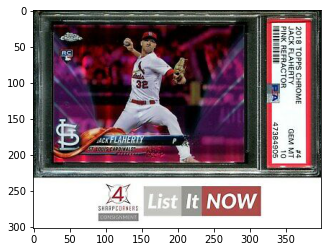

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    npimg = img
    plt.imshow(np.transpose(npimg, (0, 1, 2)))
    plt.show()

img = np.asarray(failure_img)
imshow(img)